In [22]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [7]:
filename = 'large.blif.rent'
folder = '../benchmarks/rent_files'
rent_path = os.path.join(folder,filename)

In [8]:
with open(rent_path, "rb") as fp:   # Unpickling
    rent_data = pickle.load(fp)

In [9]:
rent_data
for level in rent_data:
    print(len(level))

1
2
4
8
16
32
64
128
256
512
1024
2048
3784
2436
262


In [12]:
rent_data_flat = np.array([data_point for level in rent_data for data_point in level])

In [13]:
blocks = np.array(rent_data_flat)[:,0]
pins = np.array(rent_data_flat)[:,1]

### bin data

In [15]:
n_bins = 12

max_blocks = max(blocks)
max_blocks

8500

In [16]:
bin_factor = max_blocks**(1/(n_bins))
bin_values = []
bin_value = 1
for i in range(n_bins):
    bin_value*=bin_factor
    bin_values.append(bin_value)
bin_values[-1] += 1

In [17]:
#Sort on first column (blocks)
rent_data_flat = rent_data_flat[rent_data_flat[:,0].argsort()]

In [18]:
binned_data = []
sorted_mask = np.array([False]*len(rent_data_flat))
for bin_value in bin_values:
    bin_mask = rent_data_flat[:,0] <= bin_value
    bin_mask = bin_mask ^ sorted_mask
    binned_data.append(rent_data_flat[bin_mask])
    sorted_mask = sorted_mask | bin_mask
assert len(sorted_mask) == sorted_mask.sum()

In [20]:
bin_means = []
for data in binned_data:
    blocks_mean = data[:,0].mean()
    pins_mean = data[:,1].mean()
    bin_means.append([blocks_mean, pins_mean])
bin_means = np.array(bin_means)

### Visualise data

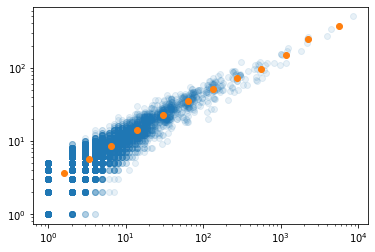

In [23]:
plt.xscale("log")
plt.yscale("log")
plt.scatter(blocks, pins, alpha = 0.1)
plt.scatter(bin_means[:,0], bin_means[:,1])

### Find rent exponent

In [24]:
log_bin_means = np.log(bin_means)

In [25]:
def trend_line(data):
    x = data[:,0]
    y = data[:,1]
    x_mean = x.mean()
    y_mean = y.mean()
    x_err = x-x_mean
    y_err = y-y_mean
    a = (x_err*y_err).sum()/ ((x_err)**2).sum()
    b = y_mean - x_mean*a
    first_point = [x[0], x[0]*a + b]
    last_point = [x[-1], x[-1]*a + b]
    
    #Error
    error = sum((y - (x*a + b))**2)/len(data)   
    
    return np.array([first_point, last_point]), a, b, error

In [26]:
trend_line(log_bin_means[:])

(array([[0.47443697, 1.37674885],
        [8.64235633, 5.96003069]]),
 0.5611321113147675,
 1.1105270342431854,
 0.0049948446581129765)

In [27]:
int(n_bins/2)
n_selected_bins = 6
error_per_n_bins = [] ##Find the best error for sliding windows of selected number of bins
for n_selected_bins in range(int(3), n_bins+1):
    print(n_selected_bins)
    min_error = np.inf
    min_error_data = []
    for i in range(n_bins-n_selected_bins+1):
        line, slope, offset, error = trend_line(log_bin_means[i:i+n_selected_bins])
        if error < min_error:
            min_error = error
            min_error_data = log_bin_means[i:i+n_selected_bins]
    error_per_n_bins.append([n_selected_bins, min_error_data, min_error]) 
error_per_n_bins = np.array(error_per_n_bins, dtype=object)

3
4
5
6
7
8
9
10
11
12


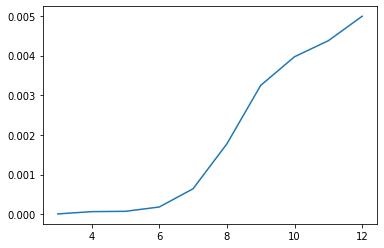

In [28]:
plt.plot(error_per_n_bins[:, 0], error_per_n_bins[:, -1])

In [29]:
error_per_n_bins[:, -1]

array([5.260927463932915e-06, 6.249931692500811e-05,
       7.108220110884698e-05, 0.00017981886462604098,
       0.0006399226785995161, 0.0017739051506365843,
       0.0032494902625899223, 0.003972718479780919, 0.0043776456790316325,
       0.0049948446581129765], dtype=object)

In [30]:
##find best number of bins (to ommit rents first and second 'gebied' )
best_n_bins = 8 ## find this automatically ## find minimum and ... (? nog bedenken hoe juist)
selected_bins = error_per_n_bins[:,1][error_per_n_bins[:, 0] == best_n_bins][0]

trend_line(selected_bins)

(array([[0.47443697, 1.32378012],
        [5.60614668, 4.35374735]]),
 0.5904401081473962,
 1.0436535013881076,
 0.0017739051506365843)

0.5904401081473962


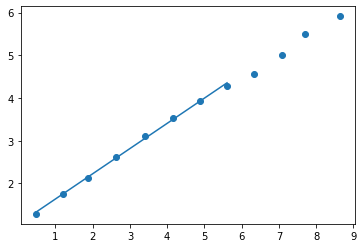

In [32]:
line, slope, offset, error = trend_line(selected_bins)
print(slope)
plt.scatter(log_bin_means[:,0], log_bin_means[:,1])

plt.plot(line[:,0], line[:,1])

In [38]:
print('rent exponent:', slope)

rent exponent: 0.5904401081473962
